### Pulsar detection using median stacking of image pixels
One of the most widely used formats for astronomical images is the Flexible Image Transport System. In a FITS file, the image is stored in a numerical array, which we can load into a NumPy array. FITS files also have headers which store metadata about the image. We're going to use the [Astropy](https://docs.astropy.org/en/stable/io/fits/) module.

Quoting from [An Introduction to Pulsars](https://www.atnf.csiro.au/outreach/education/everyone/pulsars/index.html):

In 1934 Walter Baade and Fritz Zwicky predicted the existence of neutron stars: stars which have collapsed under their own gravity during a supernova explosion. Stars like our Sun will not form neutron stars. After exhausting all their fuel, such small stars become white dwarfs. Only very massive stars (at least a few times more massive than our Sun) will undergo a supernova explosion and become neutron stars. Even more massive stars will collapse to form black holes.

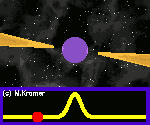

It was thought that neutron stars would never be detectable using telescopes on Earth. They were predicted to be very dense, to spin very fast, have a tiny radius of only about 10km and to possess large magnetic fields. However, we now know that charged particles moving along the magnetic field could cause beams of radiation to be emitted from the magnetic poles. Then, as the neutron star rotates, the beam would sweep across space. When this beam is in the direction of the Earth, a pulse may be detectable using a radio telescope (see the animation above).

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
# function that calculates the running mean and stdev for a list of FITS files using Welford's method.
def running_stats(filenames):
    n = 0
    for filename in filenames:
        hdulist = fits.open(filename)
        data = hdulist[0].data
        if n == 0:
            mean = np.zeros_like(data)
            s = np.zeros_like(data)
        n += 1
        delta = data - mean
        mean += delta/n
        s += delta*(data - mean)
        hdulist.close()
    s /= n - 1
    np.sqrt(s, s)
    if n < 2:
        return mean, None
    else:
        return mean, s

# function that calculates the median of a set of FITS files
def median_bins_fits(filenames, B):
    # Calculate the mean and standard dev
    mean, std = running_stats(filenames)
    # dimension of the FITS file arrays
    dim = mean.shape

    # Initialise bins
    left_bin = np.zeros(dim)
    bins = np.zeros((dim[0], dim[1], B))
    bin_width = 2 * std / B 

    # Loop over all FITS files
    for filename in filenames:
        hdulist = fits.open(filename)
        data = hdulist[0].data
        # Loop over every point in the 2D array
        for i in range(dim[0]):
            for j in range(dim[1]):
                value = data[i, j]
                mean_ = mean[i, j]
                std_ = std[i, j]
                if value < mean_ - std_:
                    left_bin[i, j] += 1
                elif value >= mean_ - std_ and value < mean_ + std_:
                    bin = int((value - (mean_ - std_))/bin_width[i, j])
                    bins[i, j, bin] += 1

    return mean, std, left_bin, bins

# function
def median_approx_fits(filenames, B):
    mean, std, left_bin, bins = median_bins_fits(filenames, B)
    dim = mean.shape # Dimension of the FITS file arrays
    
    # Position of the middle element over all files
    N = len(filenames)
    mid = (N + 1)/2

    bin_width = 2*std / B
    # Calculate the approximated median for each array element
    median = np.zeros(dim)   
    for i in range(dim[0]):
        for j in range(dim[1]):    
            count = left_bin[i, j]
            for b, bincount in enumerate(bins[i, j]):
                count += bincount
                if count >= mid:
                    # stop when the cumulative count exceeds the midpoint
                    break
            median[i, j] = mean[i, j] - std[i, j] + bin_width[i, j]*(b + 0.5)
      
    return median

mean: 0.014341139149936764
std: 0.008442678900729538
left_bin: 0.0
bins: [4. 5. 0. 0.]
median: 0.012230469424754378


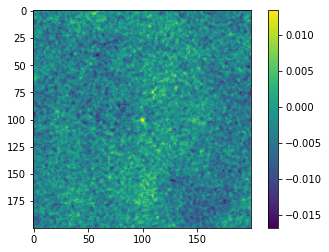

In [3]:
mean, std, left_bin, bins = median_bins_fits(['fits/image{}.fits'.format(str(i)) for i in range(11)], 4)
median = median_approx_fits(['fits/image{}.fits'.format(str(i)) for i in range(11)], 4)
print('mean:', mean[100, 100])
print('std:', std[100, 100])
print('left_bin:', left_bin[100, 100])
print('bins:', bins[100, 100, :])
print('median:', median[100, 100])

# plot the result
plt.imshow(median, cmap=plt.cm.viridis)
plt.colorbar()
plt.show()